## 04. PyTorch Custom Datasets Exercises Template

In [1]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "gpu" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_built() else "cpu"
device

2.1.0.dev20230709


'mps'

### 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

- (1) Add more layers/units to model
    - it may not have enough capability to learn the required patterns/weights/representations of the data
- (2) Tweak the learning rate
    - the laerning rate may be too high to begin with, which is trying to update the wights too much
- (3) Train longer
    - model need more time to learn the representations of data

### 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [2]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

if image_path.is_dir():
    print(image_path, "directory already exists...")
else:
    print(image_path, "does not exist, creating...")
    image_path.mkdir(parents=True, exist_ok=True)


data/pizza_steak_sushi_20_percent directory already exists...


In [3]:
# downloading the pizza_steak_sushi_20_percent.zip file
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading...")
    f.write(request.content)

# unzip the file data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

Downloading...
Unzipping...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
    """ walks through dir_path returning file counts of its contents """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.


In [6]:
# set up train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [7]:
# visualize random image
import random
from PIL import Image

# get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg')]

(-0.5, 511.5, 511.5, -0.5)

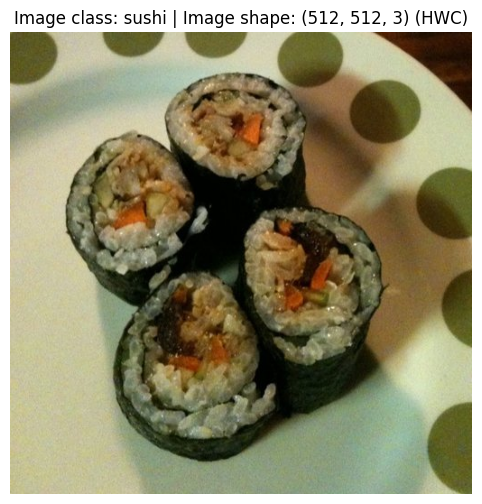

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# pick a random image
random_image_path = random.choice(image_path_list)
# get the class of the image
image_class = random_image_path.parent.stem
# open image
img = Image.open(random_image_path)

# turn the image into an array
img_array = np.array(img)
# plot the image with matplotlib
plt.figure(figsize=(8,6))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape: {img_array.shape} (HWC)")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # resize image to 64 x 64
    transforms.Resize(size=(64, 64)),
    # flip the image randomly on the horizontal?
    transforms.RandomHorizontalFlip(p = 0.5),
    # tnru into a torch tensor
    transforms.ToTensor()
])

# test the transform
data_transform(img).shape

torch.Size([3, 64, 64])

In [11]:
# Write a function to plot transformed images
def plot_transform_img(image_path:list, transform, n=3, seed=None):
    """
    select random images from 'image_path',load and transform them,
    and plot the original version and the transformed version
    """
    if seed:
        random.seed(seed)
    # random select n images
    random_img_path = random.sample(image_path, k=n)

    for image_path in random_img_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # transform and plot
            # need to change the shape to color channel first
            transform_img = transform(f).permute(1, 2, 0)
            ax[1].imshow(transform_img)
            ax[1].set_title(f"Transformed\nShape: {transform_img.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)

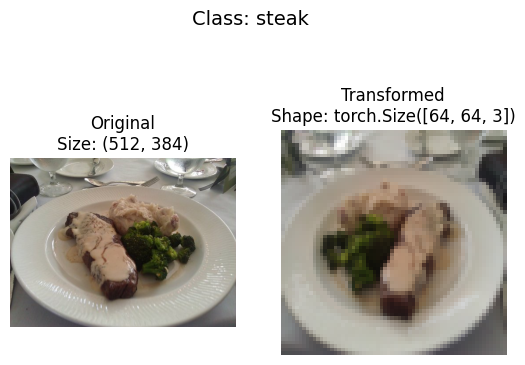

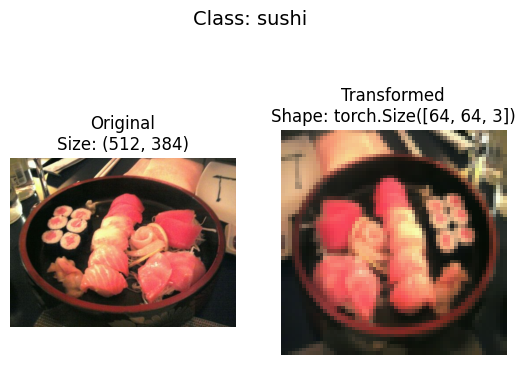

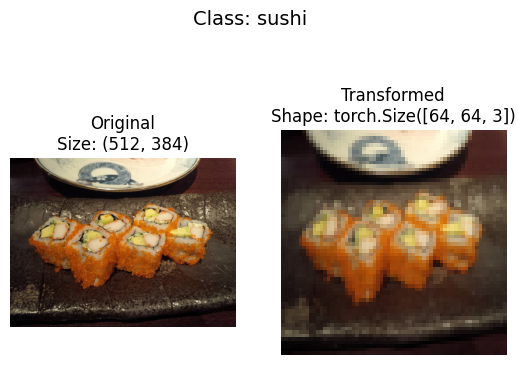

In [12]:
plot_transform_img(image_path_list, data_transform, n=3, seed=None)

#### Load image data using `ImageFolder`

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # trasform for the data
                                  target_transform=None)    # trasform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(450, 150)

In [17]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16e0ee770>,
 <torch.utils.data.dataloader.DataLoader at 0x16e0ed360>)

In [18]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(15, 5)

### 3. Recreate `model_0` we built in section 7 of notebook 04.

In [19]:
class TinyVGG_V0(nn.Module):
    """ model architecture copying TingVGG from CNN Explainer """
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.con_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.con_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 15 * 15, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.con_block_1(x)
        x = self.con_block_2(x)
        x = self.classifier(x)
        return x

### 4. Create training and testing functions for `model_0`.

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader and data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad 
        optimizer.zero_grad()
        # 4. Loss backward 
        loss.backward()
        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumualte accuracy metric across all batches
        pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and average accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc
    

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  
    # Put model in eval mode
    model.eval()

    # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X,y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculuate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_label = test_pred.argmax(dim=1)
            test_acc += (test_label == y).sum().item() / len(test_label)
      
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [22]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

    # Create results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # Loop through the training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Train step
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        # Test step
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
            
        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        # Update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the results dictionary
    return results

### 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [23]:
# add a function to plot the results
def plot_loss_curves(results):
    """ plots training curves of a results dictionary """
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(train_loss))

    plt.figure(figsize=(16,8))

    # plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()

    # plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()

#### 5 epochs

In [24]:
# Train for 5 epochs
from timeit import default_timer as timer
NUM_EPOCHS = 5

torch.manual_seed(42)
# create an instance of the model
model_0 = TinyVGG_V0(input_shape=3,
                     hidden_units=10,
                     output_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()
model_0_5epo_results = train(model=model_0,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=NUM_EPOCHS,
                             device="cpu")
end_time = timer()
print(f"Total training time for 5 epochs: {end_time - start_time:.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1011 | train_acc: 0.3292 | test_loss: 1.0986 | test_acc: 0.5000
Epoch: 2 | train_loss: 1.0960 | train_acc: 0.4500 | test_loss: 1.0803 | test_acc: 0.4313
Epoch: 3 | train_loss: 1.0725 | train_acc: 0.4771 | test_loss: 1.0494 | test_acc: 0.5352
Epoch: 4 | train_loss: 1.0035 | train_acc: 0.5625 | test_loss: 0.9619 | test_acc: 0.5545
Epoch: 5 | train_loss: 0.9072 | train_acc: 0.6000 | test_loss: 0.9215 | test_acc: 0.5256
Total training time for 5 epochs: 11.883 seconds.


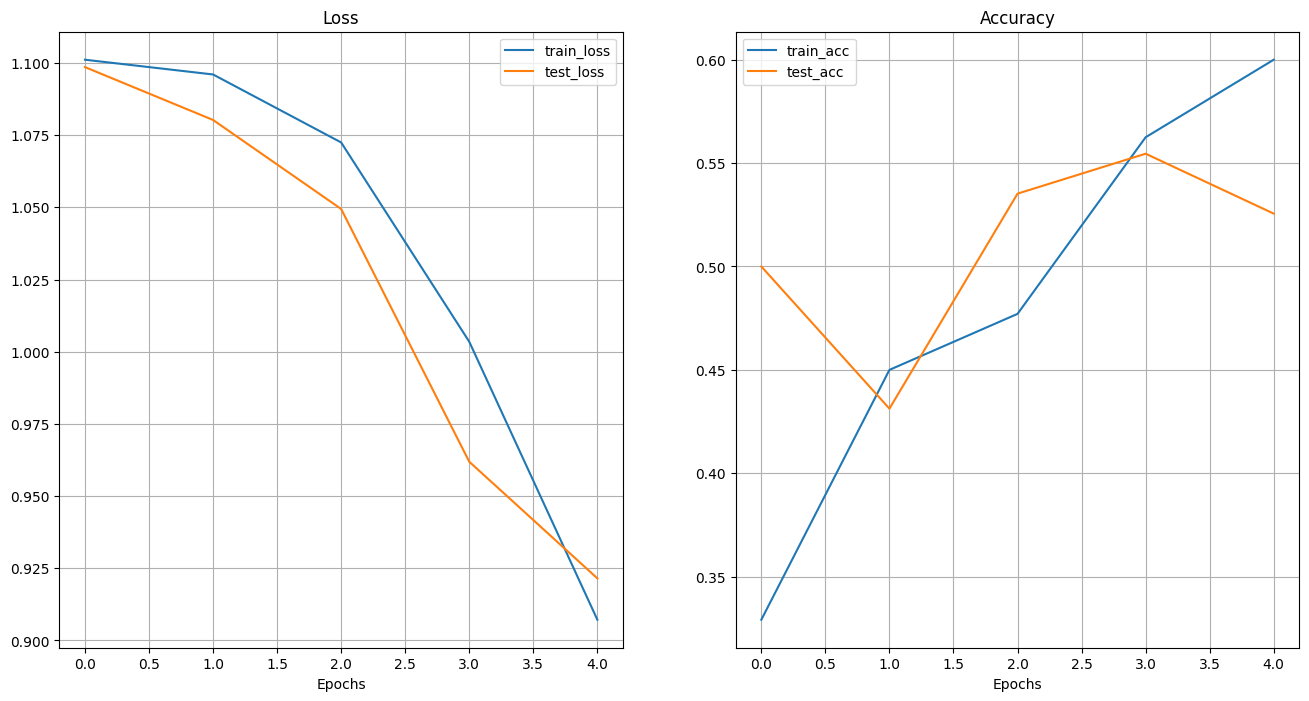

In [25]:
plot_loss_curves(model_0_5epo_results)

#### 20 epochs

In [26]:
# Train for 20 epochs
NUM_EPOCHS = 20

torch.manual_seed(42)
# create an instance of the model
model_0 = TinyVGG_V0(input_shape=3,
                     hidden_units=10,
                     output_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()
model_0_20epo_results = train(model=model_0,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=NUM_EPOCHS,
                              device="cpu")
end_time = timer()
print(f"Total training time for 20 epochs: {end_time - start_time:.3f} seconds.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1011 | train_acc: 0.3292 | test_loss: 1.0986 | test_acc: 0.5000
Epoch: 2 | train_loss: 1.0960 | train_acc: 0.4500 | test_loss: 1.0803 | test_acc: 0.4313
Epoch: 3 | train_loss: 1.0725 | train_acc: 0.4771 | test_loss: 1.0494 | test_acc: 0.5352
Epoch: 4 | train_loss: 1.0035 | train_acc: 0.5625 | test_loss: 0.9619 | test_acc: 0.5545
Epoch: 5 | train_loss: 0.9072 | train_acc: 0.6000 | test_loss: 0.9215 | test_acc: 0.5256
Epoch: 6 | train_loss: 0.9253 | train_acc: 0.5583 | test_loss: 0.9258 | test_acc: 0.5915
Epoch: 7 | train_loss: 0.9332 | train_acc: 0.5500 | test_loss: 0.9160 | test_acc: 0.5784
Epoch: 8 | train_loss: 0.8260 | train_acc: 0.6375 | test_loss: 0.9086 | test_acc: 0.5977
Epoch: 9 | train_loss: 0.8752 | train_acc: 0.6271 | test_loss: 0.9519 | test_acc: 0.5210
Epoch: 10 | train_loss: 0.8879 | train_acc: 0.5813 | test_loss: 0.8961 | test_acc: 0.6102
Epoch: 11 | train_loss: 0.8222 | train_acc: 0.6542 | test_loss: 0.9006 | test_acc: 0.6256
Epoch: 12 | train_l

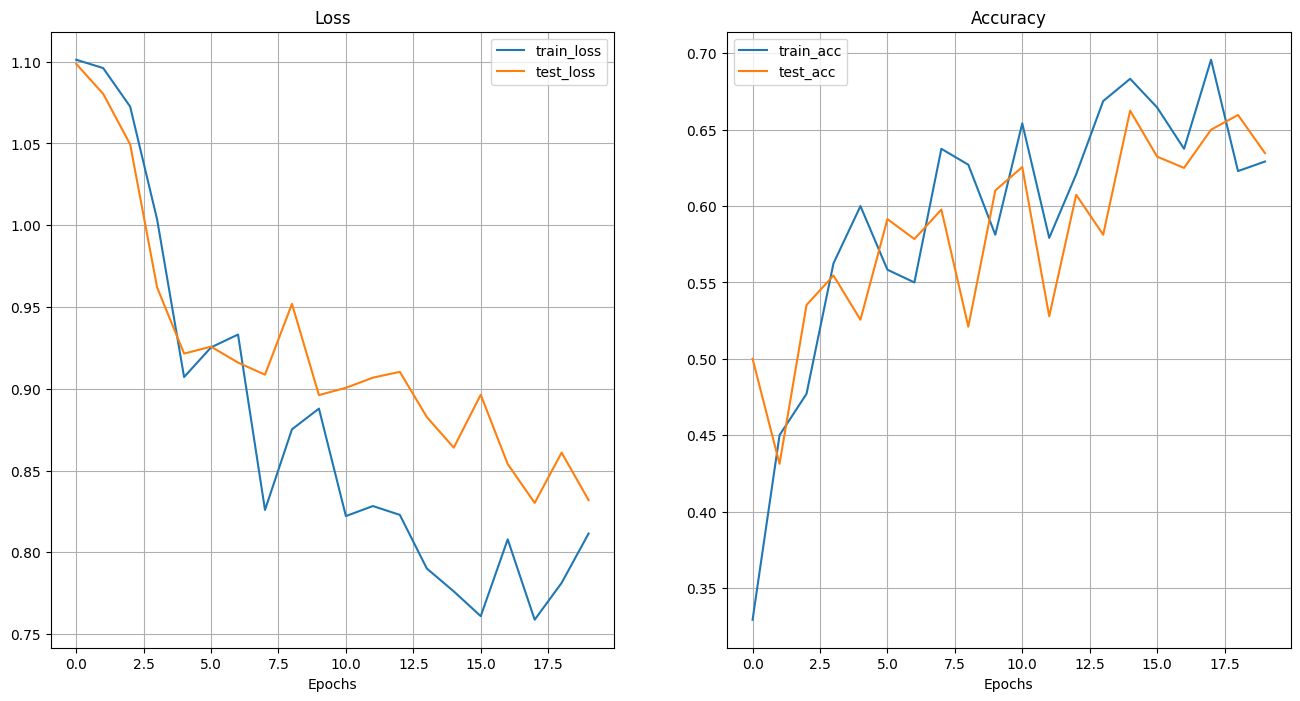

In [27]:
plot_loss_curves(model_0_20epo_results)

#### 50 epochs

In [28]:
# Train for 50 epochs
NUM_EPOCHS = 50

torch.manual_seed(42)
# create an instance of the model
model_0 = TinyVGG_V0(input_shape=3,
                     hidden_units=10,
                     output_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()
model_0_50epo_results = train(model=model_0,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=NUM_EPOCHS,
                              device="cpu")
end_time = timer()
print(f"Total training time for 50 epochs: {end_time - start_time:.3f} seconds.")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1011 | train_acc: 0.3292 | test_loss: 1.0986 | test_acc: 0.5000
Epoch: 2 | train_loss: 1.0960 | train_acc: 0.4500 | test_loss: 1.0803 | test_acc: 0.4313
Epoch: 3 | train_loss: 1.0725 | train_acc: 0.4771 | test_loss: 1.0494 | test_acc: 0.5352
Epoch: 4 | train_loss: 1.0035 | train_acc: 0.5625 | test_loss: 0.9619 | test_acc: 0.5545
Epoch: 5 | train_loss: 0.9072 | train_acc: 0.6000 | test_loss: 0.9215 | test_acc: 0.5256
Epoch: 6 | train_loss: 0.9253 | train_acc: 0.5583 | test_loss: 0.9258 | test_acc: 0.5915
Epoch: 7 | train_loss: 0.9332 | train_acc: 0.5500 | test_loss: 0.9160 | test_acc: 0.5784
Epoch: 8 | train_loss: 0.8260 | train_acc: 0.6375 | test_loss: 0.9086 | test_acc: 0.5977
Epoch: 9 | train_loss: 0.8752 | train_acc: 0.6271 | test_loss: 0.9519 | test_acc: 0.5210
Epoch: 10 | train_loss: 0.8879 | train_acc: 0.5813 | test_loss: 0.8961 | test_acc: 0.6102
Epoch: 11 | train_loss: 0.8222 | train_acc: 0.6542 | test_loss: 0.9006 | test_acc: 0.6256
Epoch: 12 | train_l

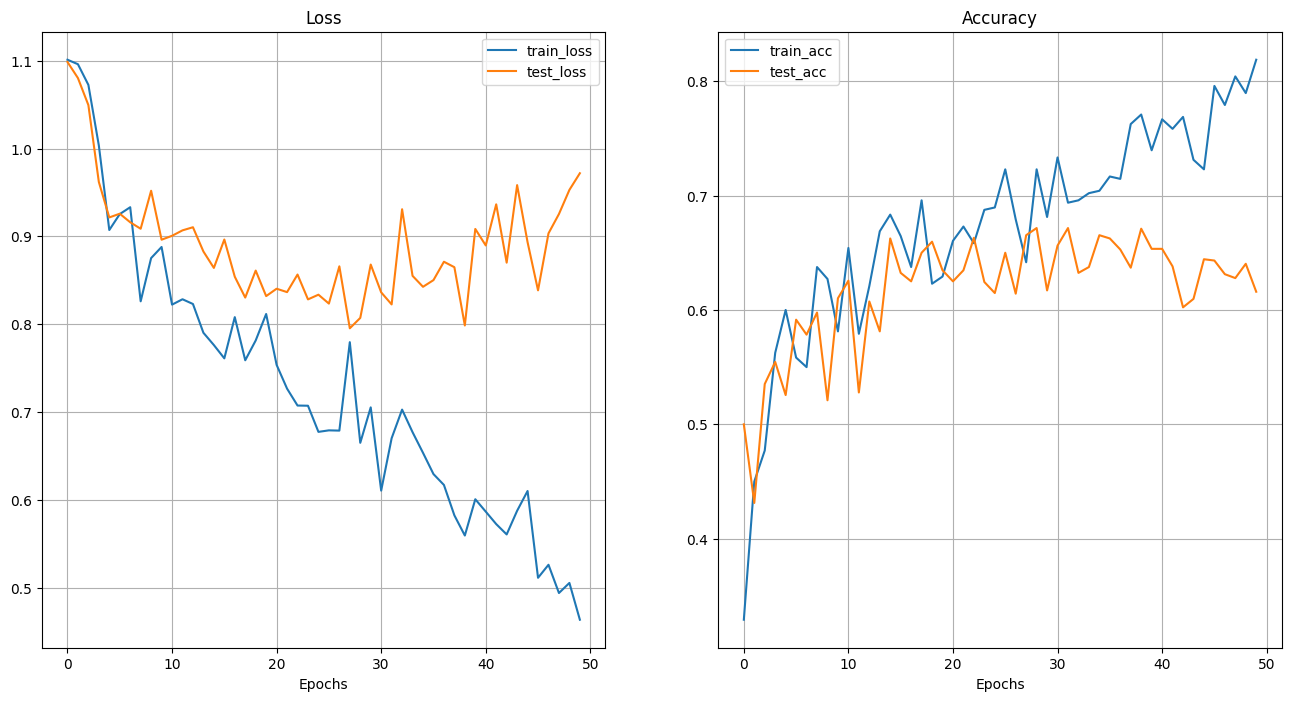

In [29]:
plot_loss_curves(model_0_50epo_results)

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

### 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [30]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
NUM_EPOCHS = 20

model_1 = TinyVGG_V0(input_shape=3,
                     hidden_units=20,
                     output_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

start_time = timer()
model_1_20epo_results = train(model=model_1,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=NUM_EPOCHS,
                              device="cpu")
end_time = timer()
print(f"Total training time for 20 epochs: {end_time - start_time:.3f} seconds.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1010 | train_acc: 0.3375 | test_loss: 1.0977 | test_acc: 0.3966
Epoch: 2 | train_loss: 1.0878 | train_acc: 0.3792 | test_loss: 1.0723 | test_acc: 0.4619
Epoch: 3 | train_loss: 1.0139 | train_acc: 0.4833 | test_loss: 1.0588 | test_acc: 0.4205
Epoch: 4 | train_loss: 0.9773 | train_acc: 0.5417 | test_loss: 0.8740 | test_acc: 0.6028
Epoch: 5 | train_loss: 0.8919 | train_acc: 0.5854 | test_loss: 0.8816 | test_acc: 0.5875
Epoch: 6 | train_loss: 0.8754 | train_acc: 0.6062 | test_loss: 0.8956 | test_acc: 0.5932
Epoch: 7 | train_loss: 0.8558 | train_acc: 0.5813 | test_loss: 0.8945 | test_acc: 0.5489
Epoch: 8 | train_loss: 0.8464 | train_acc: 0.5729 | test_loss: 0.8836 | test_acc: 0.6125
Epoch: 9 | train_loss: 0.8684 | train_acc: 0.5896 | test_loss: 0.8904 | test_acc: 0.5830
Epoch: 10 | train_loss: 0.8776 | train_acc: 0.6104 | test_loss: 0.8882 | test_acc: 0.5824
Epoch: 11 | train_loss: 0.8630 | train_acc: 0.6104 | test_loss: 0.9241 | test_acc: 0.5818
Epoch: 12 | train_l

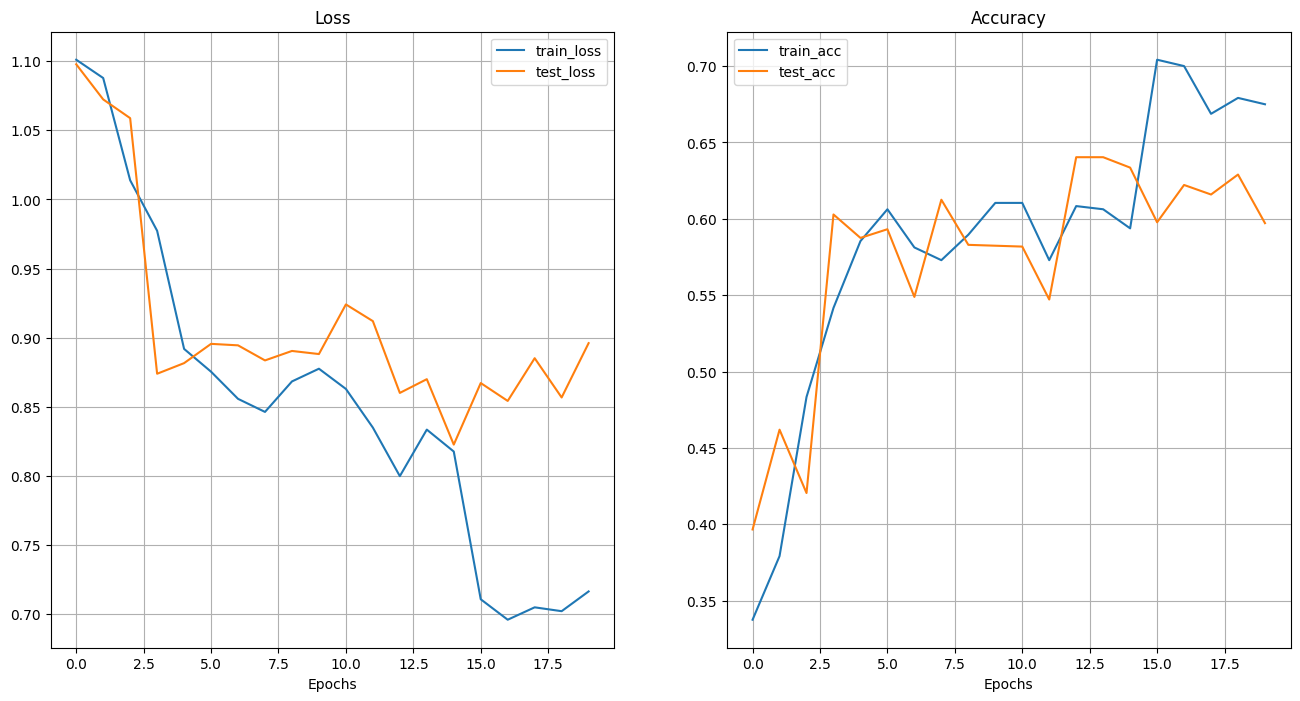

In [31]:
plot_loss_curves(model_1_20epo_results)

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

### 7. Augment the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?

In [32]:
# look at trivialaugment
train_trivialaugment = transforms.Compose([
    transforms.Resize(size=(64,64)),
    # how instance want the sugmentation to happen
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

In [33]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[0]

PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg')

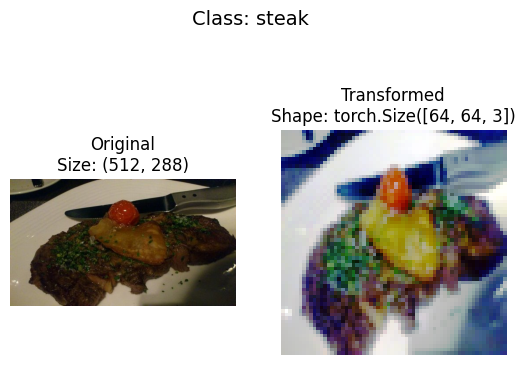

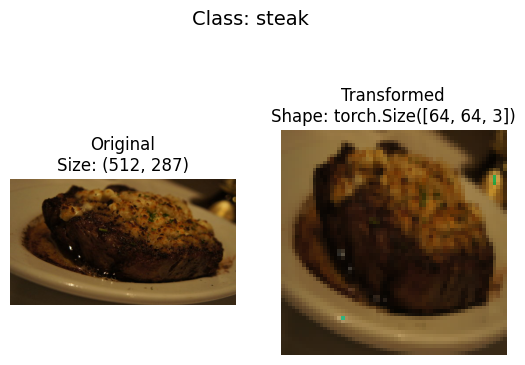

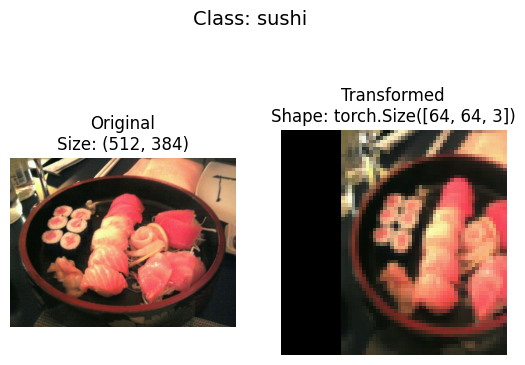

In [34]:
# see some random transformed images
plot_transform_img(image_path_list, train_trivialaugment, n=3, seed=None)

In [35]:
# turn image folder into datasets
train_data_augment = datasets.ImageFolder(root=train_dir,
                                          transform=train_trivialaugment)
test_data_augment = datasets.ImageFolder(root=test_dir,
                                         transform=test_transforms)

train_data_augment, test_data_augment

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [36]:
# turn dataseys into dataloaders
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augment = DataLoader(train_data_augment, BATCH_SIZE, True)
test_dataloader_augment = DataLoader(test_data_augment, BATCH_SIZE, False)

train_dataloader_augment, test_dataloader_augment

(<torch.utils.data.dataloader.DataLoader at 0x16e27da50>,
 <torch.utils.data.dataloader.DataLoader at 0x17f5a6140>)

In [37]:
# Train a model with increased amount of data
torch.manual_seed(42)
NUM_EPOCHS = 20

model_2 = TinyVGG_V0(input_shape=3,
                     hidden_units=20,
                     output_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

start_time = timer()
model_2_20epo_results = train(model=model_2,
                              train_dataloader=train_dataloader_augment,
                              test_dataloader=test_dataloader_augment,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=NUM_EPOCHS,
                              device="cpu")
end_time = timer()
print(f"Total training time for 20 epochs: {end_time - start_time:.3f} seconds.")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1004 | train_acc: 0.3438 | test_loss: 1.0995 | test_acc: 0.2938
Epoch: 2 | train_loss: 1.0979 | train_acc: 0.3312 | test_loss: 1.0844 | test_acc: 0.4142
Epoch: 3 | train_loss: 1.0675 | train_acc: 0.4729 | test_loss: 1.0376 | test_acc: 0.4591
Epoch: 4 | train_loss: 1.0344 | train_acc: 0.4958 | test_loss: 0.9719 | test_acc: 0.4602
Epoch: 5 | train_loss: 1.0392 | train_acc: 0.4521 | test_loss: 0.9512 | test_acc: 0.5551
Epoch: 6 | train_loss: 1.0121 | train_acc: 0.4792 | test_loss: 0.9683 | test_acc: 0.5239
Epoch: 7 | train_loss: 0.9981 | train_acc: 0.4938 | test_loss: 0.9211 | test_acc: 0.5881
Epoch: 8 | train_loss: 1.0013 | train_acc: 0.5000 | test_loss: 0.9266 | test_acc: 0.5568
Epoch: 9 | train_loss: 0.9566 | train_acc: 0.5167 | test_loss: 0.9369 | test_acc: 0.6006
Epoch: 10 | train_loss: 0.9434 | train_acc: 0.5500 | test_loss: 0.8965 | test_acc: 0.5773
Epoch: 11 | train_loss: 0.9456 | train_acc: 0.5333 | test_loss: 0.9438 | test_acc: 0.5023
Epoch: 12 | train_l

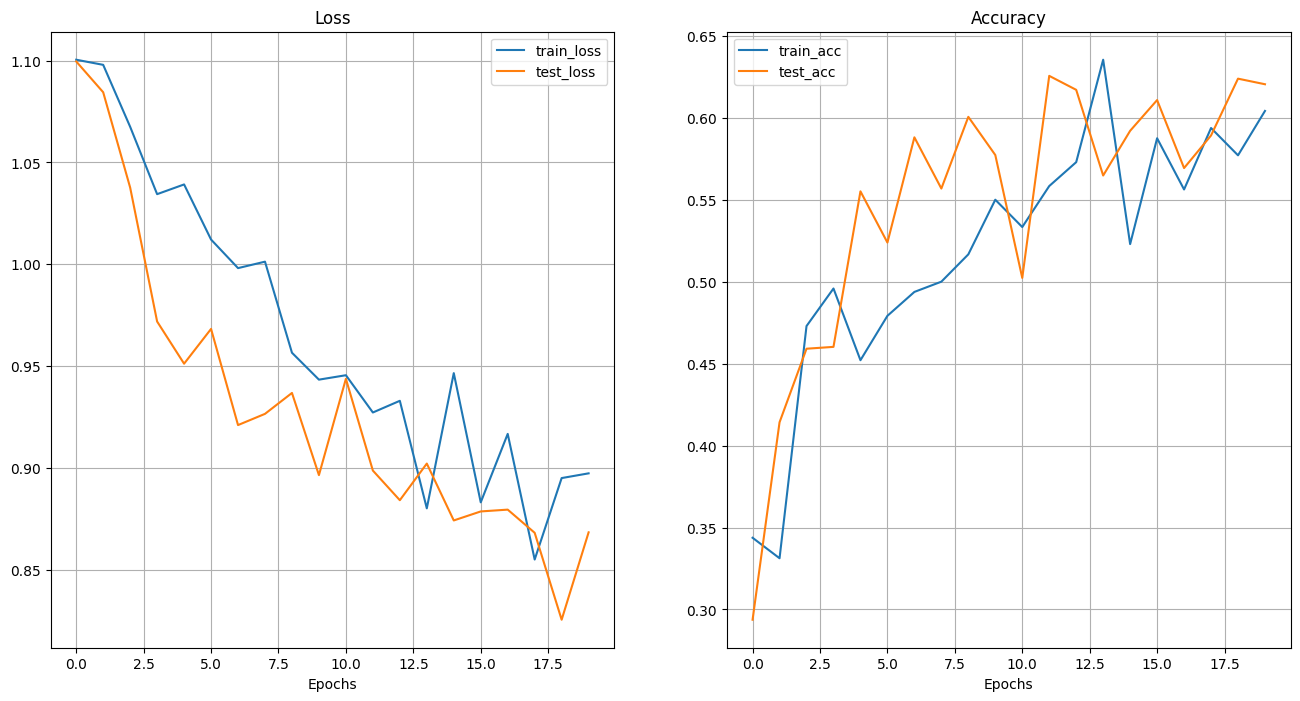

In [38]:
plot_loss_curves(model_2_20epo_results)

##### looks good

### 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [39]:
import torchvision

custom_image_path = data_path / "exe04_custom_steak.jpg"

# read in custom image -> in uint8 format
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255

# convert into 64x64
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image_uint8)
custom_image_transformed_finally = custom_image_transformed.unsqueeze(dim=0)

print(f"Custom image transformed shape: {custom_image_transformed.shape}")
print(f"Unsqueezed custom image shape: {custom_image_transformed_finally.shape}")

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


/Users/wzy/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


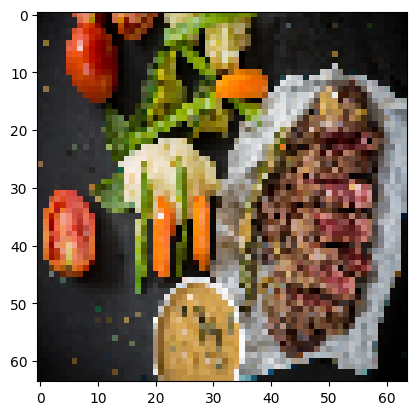

In [40]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [41]:
def pred_and_plot_image(model, image_path, class_names, transform, device):
    """ make a prediction on a target image and plots the image with its prediction """
    
    # load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255
    
    # transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # make sure the model is on the target device
    model.to(device)
    
    # turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # turn logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

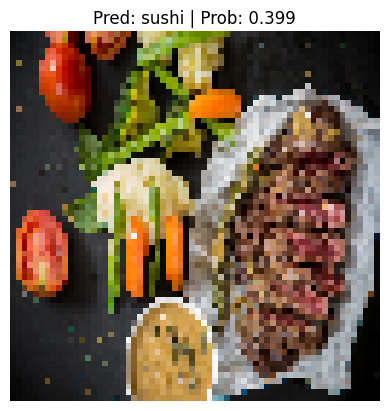

In [42]:
# pred on our custom image
pred_and_plot_image(model=model_2,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device="cpu")

In [43]:
model_2.eval()
with torch.inference_mode():
    custom_image_pred = model_2(custom_image_transformed_finally)

# prediction logits
print(f"Prediction logits: {custom_image_pred}")

# logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
print(f"Prediction class name: {custom_image_pred_class}")

Prediction logits: tensor([[-0.2659, -0.3283, -0.0130]])
Prediction probabilities: tensor([[0.3099, 0.2911, 0.3990]])
Prediction label: tensor([2])
Prediction class name: sushi


#### Wrong :( , but the probability of three clsses is quite similar

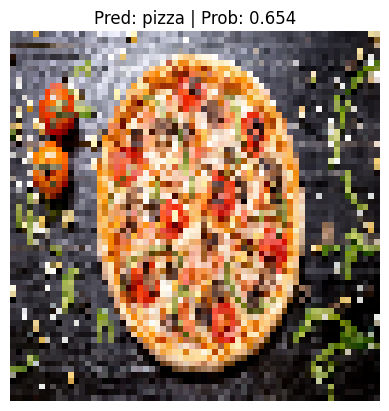

In [44]:
# try another one
custom_image_path = data_path / "exe04_custom_pizza.jpg"

pred_and_plot_image(model=model_2,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device="cpu")

#### Goooood!

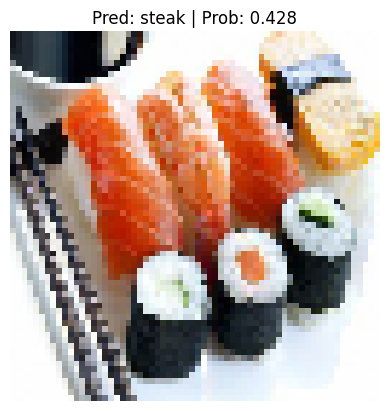

In [45]:
custom_image_path = data_path / "exe04_custom_sushi.jpeg"

pred_and_plot_image(model=model_2,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device="cpu")

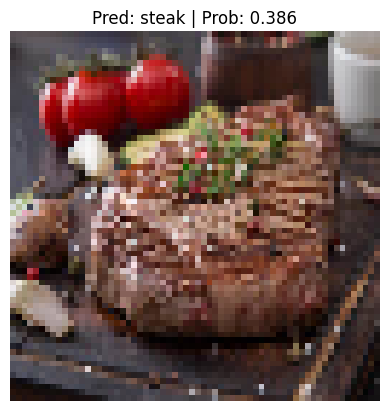

In [46]:
custom_image_path = data_path / "exe04_custom_steak2.jpeg"

pred_and_plot_image(model=model_2,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device="cpu")

### 9. Change the size of the image to a higher resolution, train the model and make predictions on the custom images

In [47]:
# Write transform for turning images into tensors
high_resol_transform = transforms.Compose([
    # resize image to 128 x 128
    transforms.Resize(size=(128, 128)),
    # flip the image randomly on the horizontal?
    transforms.RandomHorizontalFlip(p = 0.5),
    # tnru into a torch tensor
    transforms.ToTensor()
])

# test the transform
high_resol_transform(img).shape

torch.Size([3, 128, 128])

In [48]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data_high_resol = datasets.ImageFolder(
    root=train_dir,
    transform=high_resol_transform,
    target_transform=None 
)

test_data_high_resol = datasets.ImageFolder(
    root=test_dir,
    transform=high_resol_transform,
    target_transform=None
)

train_data_high_resol, test_data_high_resol

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [49]:
class_names = train_data_high_resol.classes
class_dict = train_data_high_resol.class_to_idx

class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [50]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 32

train_dataloader_high_resol = DataLoader(
    train_data_high_resol,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader_high_resol = DataLoader(
    test_data_high_resol,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader_high_resol, test_dataloader_high_resol

(<torch.utils.data.dataloader.DataLoader at 0x17f98ce80>,
 <torch.utils.data.dataloader.DataLoader at 0x17f98d9c0>)

In [51]:
# create a new model to fit new image resolution
class TinyVGG_V1(nn.Module):
    """ model architecture copying TingVGG from CNN Explainer """
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.con_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.con_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 31 * 31, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.con_block_1(x)
        x = self.con_block_2(x)
        x = self.classifier(x)
        return x

In [52]:
# Train a model with increased amount of data
torch.manual_seed(42)
NUM_EPOCHS = 20

model_3 = TinyVGG_V1(input_shape=3,
                     hidden_units=20,
                     output_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)

start_time = timer()
model_3_20epo_results = train(model=model_3,
                              train_dataloader=train_dataloader_high_resol,
                              test_dataloader=test_dataloader_high_resol,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=NUM_EPOCHS,
                              device="cpu")
end_time = timer()
print(f"Total training time for 20 epochs: {end_time - start_time:.3f} seconds.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1141 | train_acc: 0.3021 | test_loss: 1.0934 | test_acc: 0.4125
Epoch: 2 | train_loss: 1.0849 | train_acc: 0.4729 | test_loss: 1.0573 | test_acc: 0.4716
Epoch: 3 | train_loss: 1.0387 | train_acc: 0.5292 | test_loss: 0.9700 | test_acc: 0.5290
Epoch: 4 | train_loss: 0.9362 | train_acc: 0.5938 | test_loss: 0.9457 | test_acc: 0.5568
Epoch: 5 | train_loss: 0.9383 | train_acc: 0.5646 | test_loss: 0.9283 | test_acc: 0.5977
Epoch: 6 | train_loss: 0.8926 | train_acc: 0.5896 | test_loss: 0.8976 | test_acc: 0.5750
Epoch: 7 | train_loss: 0.8428 | train_acc: 0.6083 | test_loss: 0.9692 | test_acc: 0.5261
Epoch: 8 | train_loss: 0.8818 | train_acc: 0.5604 | test_loss: 0.9250 | test_acc: 0.5642
Epoch: 9 | train_loss: 0.9312 | train_acc: 0.5167 | test_loss: 0.9331 | test_acc: 0.5398
Epoch: 10 | train_loss: 0.8453 | train_acc: 0.6292 | test_loss: 0.9356 | test_acc: 0.5631
Epoch: 11 | train_loss: 0.8291 | train_acc: 0.6292 | test_loss: 0.8878 | test_acc: 0.5625
Epoch: 12 | train_l

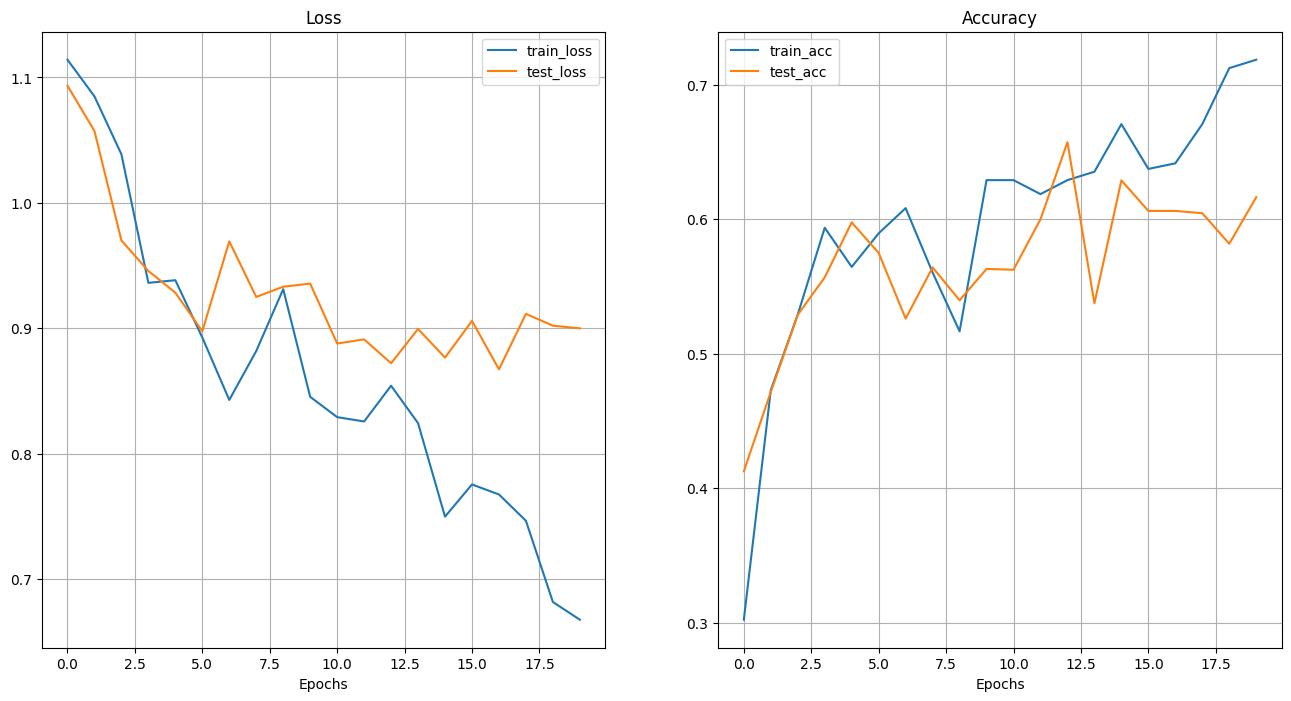

In [53]:
plot_loss_curves(model_3_20epo_results)

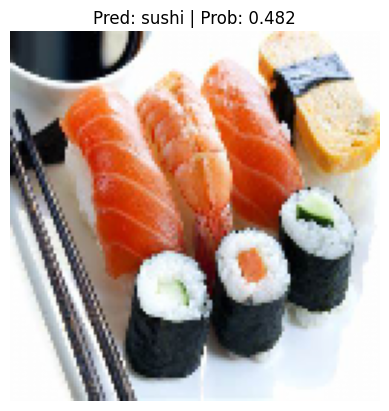

In [54]:
custom_image_path = data_path / "exe04_custom_sushi.jpeg"

# convert into 128x128
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(128, 128))
])

pred_and_plot_image(model=model_3,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device="cpu")

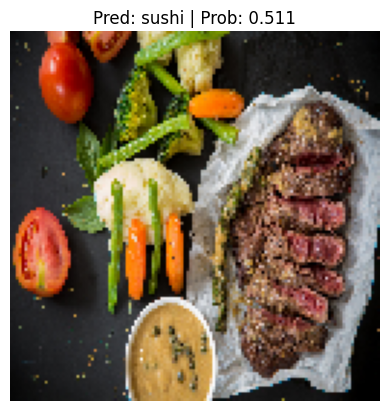

In [55]:
custom_image_path = data_path / "exe04_custom_steak.jpg"

pred_and_plot_image(model=model_3,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device="cpu")

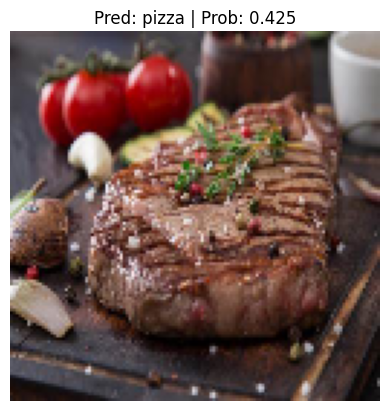

In [56]:
custom_image_path = data_path / "exe04_custom_steak2.jpeg"

pred_and_plot_image(model=model_3,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device="cpu")

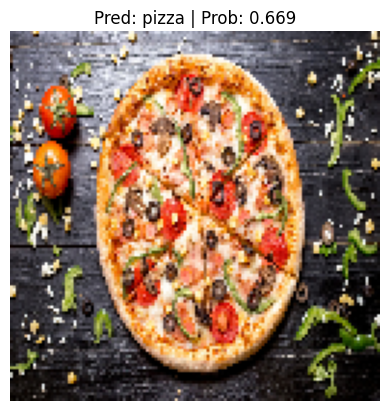

In [57]:
custom_image_path = data_path / "exe04_custom_pizza.jpg"

pred_and_plot_image(model=model_3,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device="cpu")

#### Looks like not improve the performance... :(